##  0. imports and parameters setup¶

In [1]:
# imports

from keras.applications import vgg16

from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

Using TensorFlow backend.
/Users/victorgalan/miniconda3/envs/keras_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/victorgalan/miniconda3/envs/keras_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/victorgalan/miniconda3/envs/keras_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

## Parameters setup

In [2]:
shop = 'ikea'

In [3]:
product = 'Sillas'

In [4]:
user = 'herreradelduque'

In [5]:
imgs_path = '../../data/' + 'img_' + shop.lower() + '_' + product + '/' 
imgs_path

'../../data/img_ikea_Sillas/'

## Create new users folder:

In [69]:
path_img_user = '../../data/img_users/'+ user + '/'

In [70]:
def new_user(user):
#     path = '../../data/img_users/'+ user + '/'
#     def save_img(url,directory):
    if not os.path.isdir(path_img_user):
        os.mkdir(path_img_user)

In [71]:
path_img_user

'../../data/img_users/herreradelduque/'

In [72]:
# imgs_path_users = "../../data/img_users/"

In [6]:
# parameters setup

imgs_model_width, imgs_model_height = 224, 224

num_closest_images = 5 # number of most similar images to retrieve

In [7]:
##  1. load the VGG pre-trained model from Keras¶

In [8]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

##  2. get the images paths

In [9]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

print("number of images:",len(files))

number of images: 284


In [18]:
display(files[0:5])

['../../data/img_ikea_Sillas/0071.jpg',
 '../../data/img_ikea_Sillas/0065.jpg',
 '../../data/img_ikea_Sillas/0059.jpg',
 '../../data/img_ikea_Sillas/0273.jpg',
 '../../data/img_ikea_Sillas/0267.jpg']

2.1 get users images pths

In [77]:
files_users = [path_img_user + x for x in os.listdir(path_img_user) if "jpg" or 'jpeg' in x]

print("number of users images:",len(files_users))

number of users images: 7


In [79]:
files_users[0]

'../../data/img_users/herreradelduque/Imagen 5.jpeg'

##  3. feed one image into the CNN

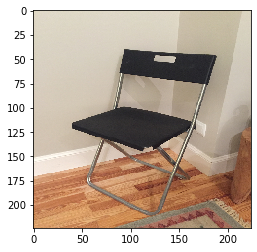

image loaded successfully!


In [101]:
# load an image in PIL format
original_user = load_img(files_users[4], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original_user)
plt.show()
print("image loaded successfully!")

In [102]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image_user = img_to_array(original_user)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch_user = np.expand_dims(numpy_image_user, axis=0)
print('image batch size', image_batch_user.shape)

# prepare the image for the VGG model
processed_image_user = preprocess_input(image_batch_user.copy())

image batch size (1, 224, 224, 3)


In [103]:
# get the extracted features
img_features_user = feat_extractor.predict(processed_image_user)

print("features successfully extracted!")
print("number of image features:",img_features_user.size)
img_features_user

features successfully extracted!
number of image features: 4096


array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 4. feed all the images into the CNN

In [96]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [97]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(284, 4096)

## 5. compute cosine similarities

In [104]:
# compute cosine similarities between images

cos_similarities = cosine_similarity(imgs_features,img_features_user)
cos_similarities = pd.DataFrame(cos_similarities, index=files)
cos_similarities_df = cos_similarities.sort_values(by=0,ascending=False)
cos_similarities_df.head(5)


,0
../../data/img_ikea_Sillas/0057.jpg,0.638510
../../data/img_ikea_Sillas/0040.jpg,0.632434
../../data/img_ikea_Sillas/0011.jpg,0.620402
../../data/img_ikea_Sillas/0062.jpg,0.602867
../../data/img_ikea_Sillas/0056.jpg,0.594527


## 6. retrieve most similar products

In [99]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):
    
    
    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")


    closest_imgs = cos_similarities_df[0].sort_values(ascending=False)[0:num_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[0].sort_values(ascending=False)[0:num_closest_images+1]


    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])
        print('image:',closest_imgs[i])

-----------------------------------------------------------------------
original product:


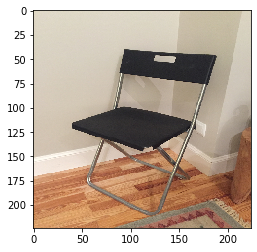

-----------------------------------------------------------------------
most similar products:


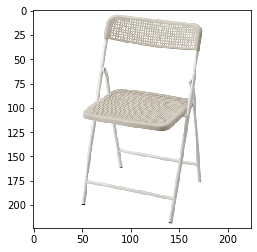

similarity score :  0.6385097
image: ../../data/img_ikea_Sillas/0057.jpg


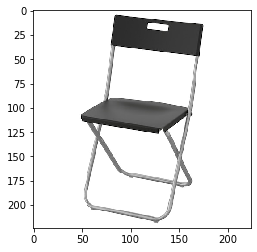

similarity score :  0.6324341
image: ../../data/img_ikea_Sillas/0040.jpg


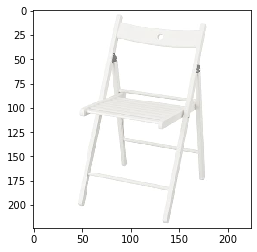

similarity score :  0.62040156
image: ../../data/img_ikea_Sillas/0011.jpg


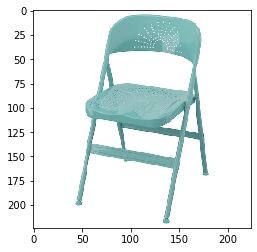

similarity score :  0.60286677
image: ../../data/img_ikea_Sillas/0062.jpg


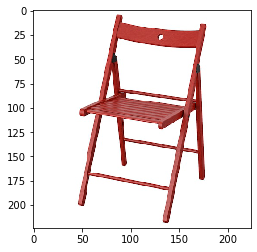

similarity score :  0.59452665
image: ../../data/img_ikea_Sillas/0056.jpg


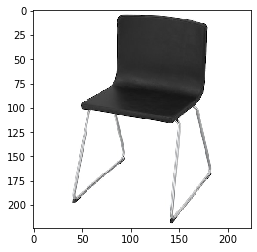

similarity score :  0.5919589
image: ../../data/img_ikea_Sillas/0140.jpg


In [105]:
retrieve_most_similar_products(files_users[4])